## Importing Libraries

In [82]:
from tensorflow.keras import layers, models   #importing of layers and models modules from tensorflows keras API
from tensorflow.keras.models import Sequential  # importing sequential class from models module
from tensorflow.keras.layers import LSTM    # importing LSTM layer from layers module
from tensorflow.keras.layers import ConvLSTM2D, Conv1D, Conv2D # importing these three layers from layers module
from tensorflow.keras.layers import MaxPooling3D
from tensorflow.keras.layers import MaxPooling2D, MaxPooling1D
from tensorflow.keras.layers import TimeDistributed 
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.utils import to_categorical   #imports the to_categorical function from TensorFlow's Keras utilities module 

from keras.optimizers import Adam   #importing short for Adaptive moment Estimation and Stochastic Gradient Descent optimization algo from keras library
from keras.optimizers import SGD  

from sklearn.model_selection import train_test_split # imports a function train_test_split from the model_selection module 
import pandas as pd  
import numpy as np
import scipy as sp
from scipy import signal #The signal submodule within SciPy for filtering, Fourier analysis, spectral estimation, and convolution
from skimage.restoration import denoise_wavelet #for image filtering, segmentation, and restoration.
import os #provides a way of using operating system-dependent functionality, such as manipulating file paths, environment variables, and executing system commands
import re #provides support for working with regular expressions in Python(text processing)

## Initialization

In [84]:
folders=['N_TXT','A_TXT'] #list of folder names contain data files
data=[] #List to store processed data  
y=0  #Counter for labeling the data from different folders
cur=0 #Counter to track the current folder index

In [85]:
for f in folders:
    cur_dir=r"C:\Users\Hari_1001\OneDrive\Documents\FinalYear_Project/"+f # to iterate over each folder

    #Depending on the file name (file), it determines pos based on the presence of substrings 'mar', 'sen', or defaults to 3 if neither is found.
    for file in os.listdir(cur_dir):
        pos=0
        if(len(re.findall('mar',file))!=0):
            pos=1 
        elif(len(re.findall('sen',file))!=0):
            pos=2 
        else:
            pos=3 

        file_fd=open(cur_dir+"/"+file,'r')
        lines=file_fd.readlines()
        
        for i in range(7,len(lines)-1):
            lines[i]=lines[i][:-1]
            temp=[cur]                          #initalize temp with current folder index
            splitted_lines=lines[i].split('\t') #Splits each line by tab (\t) into splitted_lines
            if(len(splitted_lines)<=2):
                continue                       #skips lines with fewer than or equal to 2 elements
            if(len(splitted_lines)==6):
                splitted_lines.pop()          #If splitted_lines has exactly 6 elements, removes the last one
            temp.append(pos)                  #Appends pos, parsed elements (converted to float if not empty), and y to temp.
            for j in splitted_lines:
                if(j==''):
                    temp.append(None)
                else:
                    temp.append(float(j))
            temp.append(y)
            data.append(temp)               #appends temp to data
        cur+=1
    y+=1

In [86]:
cols=['person','position','Recto Femoris','Biceps Femoris','Vasts Medialis','semitendinosus','Flexo-Extension','Abnormaility']

In [87]:
data_df=pd.DataFrame(data,columns=cols)

In [88]:
data_df

,person,position,Recto Femoris,Biceps Femoris,Vasts Medialis,semitendinosus,Flexo-Extension,Abnormaility
0,0,1,-0.0015,0.0000,0.0007,0.0000,-1.0,0
1,0,1,-0.0008,0.0015,0.0030,-0.0015,-1.0,0
2,0,1,0.0007,0.0015,0.0037,-0.0023,-1.0,0
3,0,1,-0.0008,0.0000,0.0022,-0.0015,-1.0,0
4,0,1,0.0000,-0.0008,0.0030,-0.0008,-1.0,0
...,...,...,...,...,...,...,...,...
1325217,65,2,-0.0015,-0.0046,0.0000,-0.0008,-86.8,1
1325218,65,2,-0.0008,-0.0030,-0.0008,0.0015,-87.2,1
1325219,65,2,-0.0008,-0.0030,-0.0008,0.0000,-86.9,1
1325220,65,2,-0.0023,-0.0030,-0.0023,-0.0046,-87.2,1


In [89]:
data_proc=data_df

In [90]:
data_proc=data_df.dropna().reset_index(drop=True)

In [91]:
X=np.zeros((len(data_proc),6))

In [92]:
for i in range(0,data_proc.shape[1]-2):
    X[:,i]=data_proc.iloc[:,i].values
y=np.array([i[-1] for i in data_proc.values])

In [93]:
X=np.array(X,dtype=float)

In [94]:
mu=np.nanmean(X[:,1:],axis=0)
std=np.nanstd(X[:,1:],axis=0)

In [95]:
window=500
X_seg=np.zeros((X.shape[0]-window,X.shape[1]))
y_seg=np.zeros(X.shape[0]-window)
z=0
max_per=66
for p in range(0,max_per):
    X_temp=X[X[:,0]==p]
    y_temp=y[X[:,0]==p]
    for i in range(0,X_temp.shape[0],125):
        X_seg[z]=X_temp[i]
        y_seg[z]=y_temp[i]
        X_seg[z,2:]=np.mean(X_temp[i:i+window,2:],axis=0)
        z+=1
X_seg_mean=X_seg[:z,:]
y_seg_mean=y_seg[:z]

In [96]:
window=500
X_seg=np.zeros((X.shape[0]-window,X.shape[1]))
y_seg=np.zeros(X.shape[0]-window)
z=0
max_per=66
for p in range(0,max_per):
    X_temp=X[X[:,0]==p]
    y_temp=y[X[:,0]==p]
    for i in range(0,X_temp.shape[0],125):
        X_seg[z]=X_temp[i]
        y_seg[z]=y_temp[i]
        X_seg[z,2:]=np.median(X_temp[i:i+window,2:],axis=0)
        z+=1
X_seg_median=X_seg[:z,:]
y_seg_median=y_seg[:z]

In [97]:
window = 500
X_seg = np.zeros((X.shape[0] - window, X.shape[1]))
y_seg = np.zeros(X.shape[0] - window)
z = 0
max_per = 66

for p in range(0, max_per):
    X_temp = X[X[:, 0] == p]
    y_temp = y[X[:, 0] == p]
    
    for i in range(0, X_temp.shape[0], 125):
        X_seg[z] = X_temp[i]
        y_seg[z] = y_temp[i]
        X_seg[z, 2:] = np.median(np.abs(X_temp[i:i+window, 2:]), axis=0)
        z += 1

X_seg_mav = X_seg[:z, :]
y_seg_mav = y_seg[:z]


In [98]:
window=500
X_seg=np.zeros((X.shape[0]-window,X.shape[1]))
y_seg=np.zeros(X.shape[0]-window)
z=0
max_per=66
for p in range(0,max_per):
    X_temp=X[X[:,0]==p]
    y_temp=y[X[:,0]==p]
    for i in range(0,X_temp.shape[0],125):
        X_seg[z]=X_temp[i]
        y_seg[z]=y_temp[i]
        X_seg[z,2:]=np.std(X_temp[i:i+window,2:],axis=0)
        z+=1
X_seg_std=X_seg[:z,:]
y_seg_std=y_seg[:z]

In [99]:
X_seg_median=np.delete(X_seg_median,0,axis=1) 
X_seg_mav=np.delete(X_seg_mav,0,axis=1)  
X_seg_std=np.delete(X_seg_std,0,axis=1)  
X_seg_mean=np.delete(X_seg_mean,0,axis=1)  

In [100]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Combining features
X_combined = np.hstack((X_seg_median, X_seg_std, X_seg_mav,X_seg_mean))

# Standardizing the feature matrix
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

# Applying PCA
pca = PCA(n_components=8)  # Choosing the number of components to keep
X_pca = pca.fit_transform(X_scaled)

# Extracting the selected principal components as the final features
X_final = X_pca
y_final = y_seg_median

# Print the explained variance ratio of the selected principal components
print("Explained variance ratio:", pca.explained_variance_ratio_)


Explained variance ratio: [0.26681897 0.18126948 0.1151301  0.09123964 0.06959698 0.0607403
 0.04406091 0.03938874]


In [101]:
X_train,X_test,y_train,y_test=train_test_split(X_final,y_final,stratify=y_final,test_size=0.2)

In [102]:
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score,make_scorer,log_loss


In [103]:
ft=['q','q','q','q','q','q','q','q']
cols=['1','2','3','4','5','6','7','8']

In [104]:
dtrain = xgb.DMatrix(X_train, label=y_train,enable_categorical=True,feature_types=ft,feature_names=cols[0:8])
dtest = xgb.DMatrix(X_test, label=y_test,enable_categorical=True,feature_types=ft,feature_names=cols[0:8])

In [105]:
param = {
    'eval_metric': 'auc', 
    'eta': 0.1, 
    'objective': 'binary:logistic', 
    'gamma': 1, 
    'max_depth': 10
}

In [106]:
num_round = 10000
evallist = [(dtrain, 'train'), (dtest, 'eval')]
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)

[0]	train-auc:0.98179	eval-auc:0.95991
[1]	train-auc:0.98656	eval-auc:0.96920
[2]	train-auc:0.99022	eval-auc:0.97528
[3]	train-auc:0.99036	eval-auc:0.97544
[4]	train-auc:0.99102	eval-auc:0.97635
[5]	train-auc:0.99172	eval-auc:0.97710


C:\Users\Hari_1001\anaconda3\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[6]	train-auc:0.99246	eval-auc:0.97879
[7]	train-auc:0.99286	eval-auc:0.97852
[8]	train-auc:0.99333	eval-auc:0.97879
[9]	train-auc:0.99417	eval-auc:0.98035
[10]	train-auc:0.99468	eval-auc:0.98062
[11]	train-auc:0.99497	eval-auc:0.98138
[12]	train-auc:0.99536	eval-auc:0.98194
[13]	train-auc:0.99563	eval-auc:0.98263
[14]	train-auc:0.99615	eval-auc:0.98418
[15]	train-auc:0.99647	eval-auc:0.98484
[16]	train-auc:0.99659	eval-auc:0.98523
[17]	train-auc:0.99671	eval-auc:0.98556
[18]	train-auc:0.99684	eval-auc:0.98596
[19]	train-auc:0.99691	eval-auc:0.98603
[20]	train-auc:0.99704	eval-auc:0.98623
[21]	train-auc:0.99718	eval-auc:0.98636
[22]	train-auc:0.99728	eval-auc:0.98651
[23]	train-auc:0.99748	eval-auc:0.98680
[24]	train-auc:0.99758	eval-auc:0.98695
[25]	train-auc:0.99780	eval-auc:0.98753
[26]	train-auc:0.99797	eval-auc:0.98806
[27]	train-auc:0.99802	eval-auc:0.98811
[28]	train-auc:0.99810	eval-auc:0.98836
[29]	train-auc:0.99817	eval-auc:0.98844
[30]	train-auc:0.99823	eval-auc:0.98870
[31]

In [107]:
y_pred=bst.predict(dtest)

In [108]:
y_pred_int = np.where(y_pred >= 0.2, 1, 0)

In [109]:
print(classification_report(y_test,y_pred_int))

              precision    recall  f1-score   support

         0.0       0.99      0.85      0.92       763
         1.0       0.92      1.00      0.96      1364

    accuracy                           0.94      2127
   macro avg       0.96      0.92      0.94      2127
weighted avg       0.95      0.94      0.94      2127



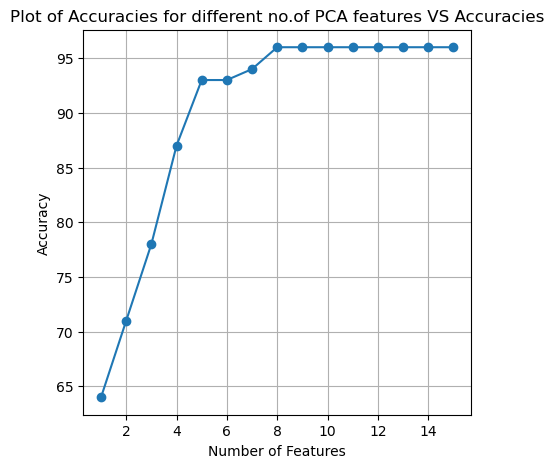

In [110]:
import matplotlib.pyplot as plt

x = range(1, 16)
y = [64, 71, 78, 87, 93, 93, 94, 96, 96, 96, 96, 96, 96, 96, 96]

plt.plot(x, y, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Plot of Accuracies for different no.of PCA features VS Accuracies')
plt.grid(True)
plt.show()


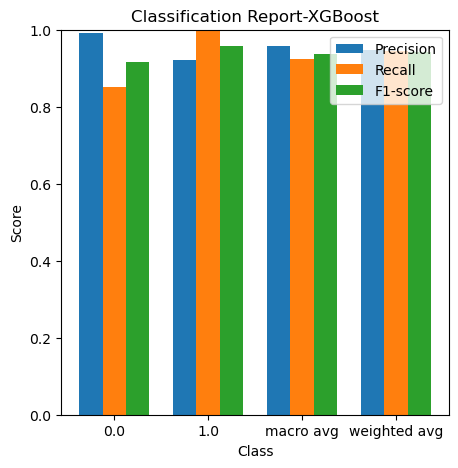

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


report = classification_report(y_test,y_pred_int, digits=2, output_dict=True)


class_labels = list(report.keys())
class_labels.remove('accuracy')

precision = [report[label]['precision'] for label in class_labels]
recall = [report[label]['recall'] for label in class_labels]
f1_score = [report[label]['f1-score'] for label in class_labels]


x = np.arange(len(class_labels))


plt.bar(x, precision, width=0.25, label='Precision')
plt.bar(x + 0.25, recall, width=0.25, label='Recall')
plt.bar(x + 0.5, f1_score, width=0.25, label='F1-score')


plt.xticks(x + 0.25, class_labels)


plt.ylim([0, 1])


plt.legend()
plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Classification Report-XGBoost')


plt.show()


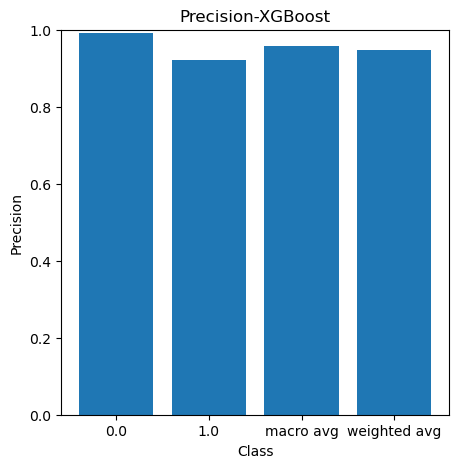

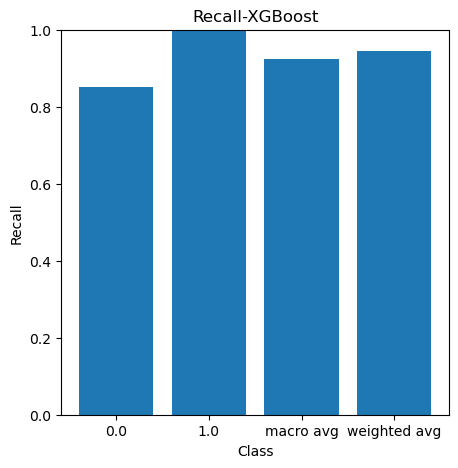

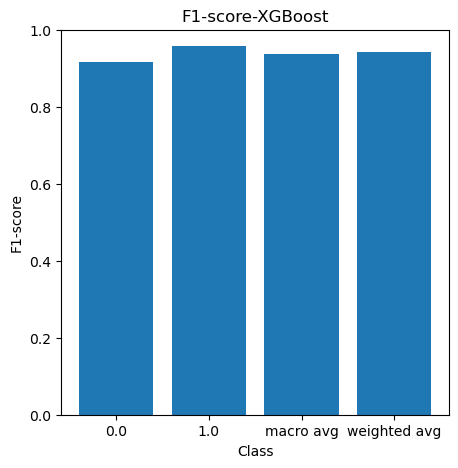

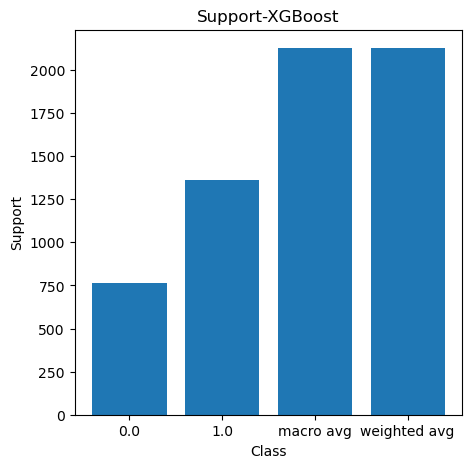

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


report = classification_report(y_test,y_pred_int, digits=2, output_dict=True)


class_labels = list(report.keys())
class_labels.remove('accuracy')

precision = [report[label]['precision'] for label in class_labels]
recall = [report[label]['recall'] for label in class_labels]
f1_score = [report[label]['f1-score'] for label in class_labels]
support = [report[label]['support'] for label in class_labels]


x = np.arange(len(class_labels))


plt.bar(x, precision)
plt.xticks(x, class_labels)
plt.ylim([0, 1])
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Precision-XGBoost')


plt.show()


plt.bar(x, recall)
plt.xticks(x, class_labels)
plt.ylim([0, 1])
plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Recall-XGBoost')


plt.show()


plt.bar(x, f1_score)
plt.xticks(x, class_labels)
plt.ylim([0, 1])
plt.xlabel('Class')
plt.ylabel('F1-score')
plt.title('F1-score-XGBoost')


plt.show()


plt.bar(x, support)
plt.xticks(x, class_labels)
plt.xlabel('Class')
plt.ylabel('Support')
plt.title('Support-XGBoost')


plt.show()


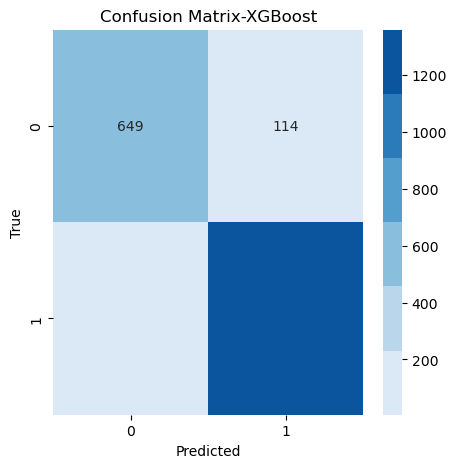

In [113]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred_int)
cmap = sns.color_palette("Blues")

sns.heatmap(cm, annot=True, cmap=cmap, fmt='d')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix-XGBoost')


plt.show()


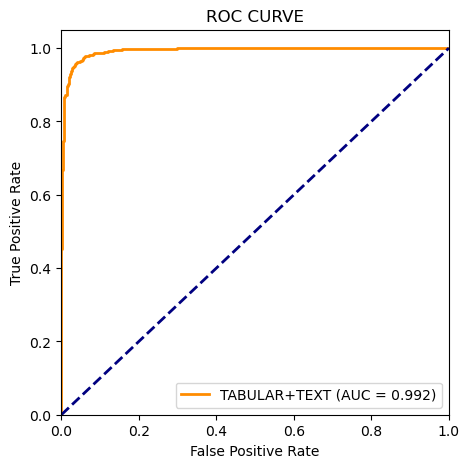

<Figure size 500x500 with 0 Axes>

In [114]:
plt.rcParams.update({'figure.figsize':(5,5), 'figure.dpi':100})
fig, axs = plt.subplots(1, 1)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
axs.plot(fpr, tpr, color='darkorange',lw=lw, label='TABULAR+TEXT (AUC = %0.3f)' % roc_auc)

axs.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
axs.set_xlim([0.0, 1.0])
axs.set_ylim([0.0, 1.05])
axs.set_xlabel('False Positive Rate')
axs.set_ylabel('True Positive Rate')
axs.set_title('ROC CURVE')
axs.legend(loc="lower right")

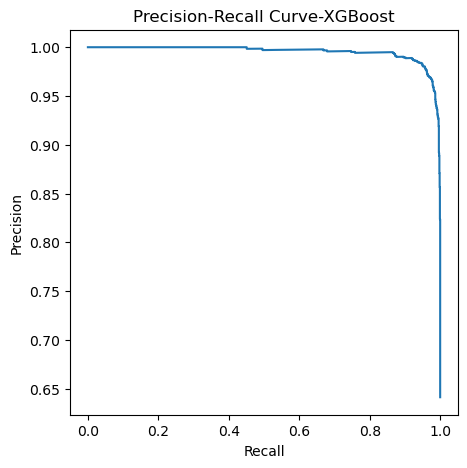

In [115]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt


precision, recall, _ = precision_recall_curve(y_test, y_pred)

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve-XGBoost')

plt.show()


In [116]:
import numpy as np
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


model = svm.SVC(kernel='rbf')  
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-Score: {:.2f}".format(f1))

Accuracy: 0.94
Precision: 0.95
Recall: 0.96
F1-Score: 0.95


In [117]:
report = classification_report(y_test, y_pred)

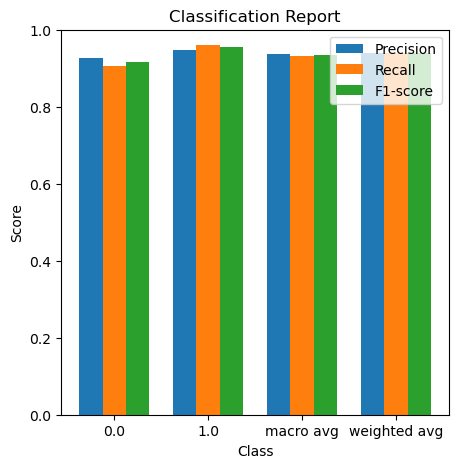

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


report = classification_report(y_test,y_pred, digits=2, output_dict=True)


class_labels = list(report.keys())
class_labels.remove('accuracy')

precision = [report[label]['precision'] for label in class_labels]
recall = [report[label]['recall'] for label in class_labels]
f1_score = [report[label]['f1-score'] for label in class_labels]

x = np.arange(len(class_labels))

plt.bar(x, precision, width=0.25, label='Precision')
plt.bar(x + 0.25, recall, width=0.25, label='Recall')
plt.bar(x + 0.5, f1_score, width=0.25, label='F1-score')

plt.xticks(x + 0.25, class_labels)

plt.ylim([0, 1])

plt.legend()
plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Classification Report')

plt.show()


In [119]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler



scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = KNeighborsClassifier(n_neighbors=5) 

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-Score: {:.2f}".format(f1))


Accuracy: 0.97
Precision: 0.98
Recall: 0.98
F1-Score: 0.98


In [120]:
report = classification_report(y_test, y_pred)

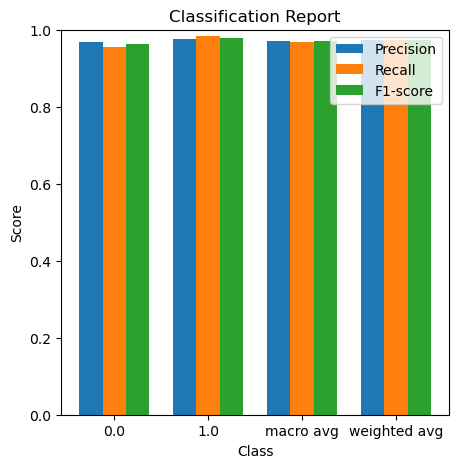

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

report = classification_report(y_test,y_pred, digits=2, output_dict=True)

class_labels = list(report.keys())
class_labels.remove('accuracy')

precision = [report[label]['precision'] for label in class_labels]
recall = [report[label]['recall'] for label in class_labels]
f1_score = [report[label]['f1-score'] for label in class_labels]

x = np.arange(len(class_labels))

plt.bar(x, precision, width=0.25, label='Precision')
plt.bar(x + 0.25, recall, width=0.25, label='Recall')
plt.bar(x + 0.5, f1_score, width=0.25, label='F1-score')

plt.xticks(x + 0.25, class_labels)

plt.ylim([0, 1])

plt.legend()
plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Classification Report')

plt.show()


In [122]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


model = LogisticRegression()

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-Score: {:.2f}".format(f1))


Accuracy: 0.68
Precision: 0.71
Recall: 0.86
F1-Score: 0.78


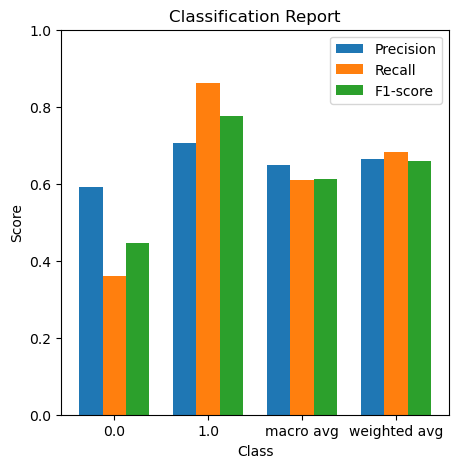

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

report = classification_report(y_test,y_pred, digits=2, output_dict=True)

class_labels = list(report.keys())
class_labels.remove('accuracy')

precision = [report[label]['precision'] for label in class_labels]
recall = [report[label]['recall'] for label in class_labels]
f1_score = [report[label]['f1-score'] for label in class_labels]

x = np.arange(len(class_labels))

plt.bar(x, precision, width=0.25, label='Precision')
plt.bar(x + 0.25, recall, width=0.25, label='Recall')
plt.bar(x + 0.5, f1_score, width=0.25, label='F1-score')

plt.xticks(x + 0.25, class_labels)

plt.ylim([0, 1])

plt.legend()
plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Classification Report')

plt.show()


In [125]:
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [129]:
X = data_df.iloc[:, :-1].values  # Extract features
y = data_df.iloc[:, -1].values   # Extract labels

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [131]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [132]:
# Check for missing values
print(data_df.isnull().sum())

# Drop rows with any missing values
data_df = data_df.dropna()

# Check the shape of the DataFrame after removing rows with missing values
print("Shape of data_df after dropping NaNs:", data_df.shape)  # Should print (number_of_samples_after_dropping, 8)


person               0
position             0
Recto Femoris      174
Biceps Femoris     174
Vasts Medialis     174
semitendinosus     174
Flexo-Extension      3
Abnormaility         0
dtype: int64
Shape of data_df after dropping NaNs: (1325045, 8)


In [133]:
# Feature extraction (all columns except the last one)
X = data_df.iloc[:, :-1].values  # Extract features
y = data_df.iloc[:, -1].values   # Extract labels

# Check the shapes of X and y
print("Shape of X:", X.shape)  # Should print (number_of_samples_after_dropping, 7)
print("Shape of y:", y.shape)  # Should print (number_of_samples_after_dropping,)

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model training
model = GaussianNB()
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

Shape of X: (1325045, 7)
Shape of y: (1325045,)


In [134]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [135]:
# Data scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [136]:
# Model training
model = GaussianNB()
model.fit(X_train_scaled, y_train)

GaussianNB()

In [137]:
# Predictions
y_pred = model.predict(X_test_scaled)

In [138]:
# Evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Use average='weighted' for multiclass
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')


In [139]:
# Print evaluation metrics
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-Score: {:.2f}".format(f1))

Accuracy: 0.94
Precision: 0.95
Recall: 0.94
F1-Score: 0.94


In [142]:
a=[94,94,97,68, 94]
b=['XGBoost','svm','KNN','log reg', 'Naive Bayes']

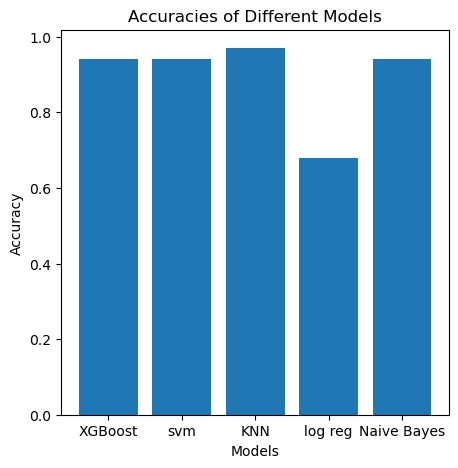

In [143]:
import matplotlib.pyplot as plt


accuracies = [0.94,0.94,0.97,0.68, 0.94]
labels = ['XGBoost','svm','KNN','log reg', 'Naive Bayes']


plt.bar(labels, accuracies)


plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracies of Different Models')

plt.show()
